This notebook makes predictions for all of the images in the smoke and nosmoke image datasets and calculates the true positives, false positives, true negatives and false negatives. For the false positives and false negatives it also writes the images to separate folders for additional analysis. It produces a Confusion Matrix chart.

In [1]:
# Setup
from tensorflow import keras
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.applications.xception import preprocess_input
import numpy as np
import os
import shutil
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix


In [2]:
# load saved model - NOTE: this takes a minute to load (it's 500mb)!
#model = tf.keras.models.load_model('MediumXception')
model = keras.models.load_model('LargeXception', compile=True)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 73,290,793
Trainable params: 73,236,265
Non-trainable params: 54,528
_________________________________________________________________


In [3]:
def getMyPrediction(name,model):
    image = keras.preprocessing.image.load_img(
    name, target_size=(299,299)   
)
    # Replace the line below with the line above.....to guard against images with incorrect image sizes
    #image = tf.keras.preprocessing.image.load_img(name)
    input_arr = keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch. 
    # Note: Xception expects a specific kind of input processing.
    # Before passing inputs to the model, call tf.keras.applications.xception.preprocess_input. 
    # It will scale scale input pixels between -1 and 1.
    x = preprocess_input(input_arr)
    predictions = model.predict(x)
    return(predictions[0][0])

# Initialize variables
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0
total_predictions = 0
y_Actual = []
y_Predicted = []

smoke_directory = r'C:\Users\mthor\Unsynced Documents\tinyall\smoke' # dataset of images containing smoke 
nosmoke_directory = r'C:\Users\mthor\Unsynced Documents\tinyall\nosmoke' # dataset of images containing no smoke 
#smoke_directory = r'C:\Users\mthor\Unsynced Documents\LargeSmoke' # dataset of images containing smoke 
#nosmoke_directory = r'C:\Users\mthor\Unsynced Documents\LargeNonSmoke' # dataset of images containing no smoke 
# NOTE: make sure these directories are empty before running this cell
false_neg_directory = r'C:\Users\mthor\Bootcamp\Wildfire-Detection\Margaret\falsenegatives'
false_pos_directory = r'C:\Users\mthor\Bootcamp\Wildfire-Detection\Margaret\falsepositives'

# go through the smoke dataset getting predictions for each image & updating counts
# if it's a false negative then copy the image to the false negatives directory

nosmoke = 0
smoke = 1

for filename in os.listdir(smoke_directory):
    if filename.endswith(".jpg"):
        name = os.path.join(smoke_directory, filename)
        prediction = getMyPrediction(name,model)
        total_predictions = total_predictions + 1
        y_Actual.append(smoke)
        
                   
        if prediction > 0.5:
            predicted = 'smoke'
            y_Predicted.append(smoke)
            true_positives = true_positives + 1
        else:
            if prediction <= 0.5:
                predicted = 'nosmoke'
                y_Predicted.append(nosmoke)
                false_negatives = false_negatives + 1
                targetfilepath = os.path.join(false_neg_directory, filename)
                shutil.copyfile(name,targetfilepath)
    
                
    else:
        continue

print(' True positives:', true_positives, ' False negatives:', false_negatives) 

# go through the nosmoke dataset getting predictions for each image & updating counts
# if it's a false positive then copy the image to the false positives directory

for filename in os.listdir(nosmoke_directory):
    if filename.endswith(".jpg"):
        name = os.path.join(nosmoke_directory, filename)
        prediction = getMyPrediction(name,model)
        total_predictions = total_predictions + 1
        y_Actual.append(nosmoke)
                   
        if prediction > 0.5:
            predicted = 'smoke'
            false_positives = false_positives + 1
            y_Predicted.append(smoke)
            targetfilepath = os.path.join(false_pos_directory, filename)
            shutil.copyfile(name,targetfilepath)
        else:
            if prediction <= 0.5:
                predicted = 'nosmoke'
                y_Predicted.append(nosmoke)
                true_negatives = true_negatives + 1
               
                
    else:
        continue
        
 
false_pos_pct = round((false_positives/total_predictions * 100),2)
false_neg_pct = round((false_negatives/total_predictions * 100),2)
true_pos_pct = round((true_positives/total_predictions * 100),2)
true_neg_pct = round((true_negatives/total_predictions * 100),2)
actual_accuracy = round((((true_positives + true_negatives)/total_predictions)*100),2)

print('Total predictions:', total_predictions, ' False positives:', false_positives, ' True negatives:', true_negatives)
print('False positives %',false_pos_pct,'\n','False negatives %',false_neg_pct, '\n','True positives %',true_pos_pct, '\n','True negatives %',true_neg_pct, '\n','Actual Accuracy %', actual_accuracy)



 True positives: 54  False negatives: 3
Total predictions: 130  False positives: 7  True negatives: 66
False positives % 5.38 
 False negatives % 2.31 
 True positives % 41.54 
 True negatives % 50.77 
 Actual Accuracy % 92.31


So, in the case of the LargeXception model, the Actual accuracy is less than the stats produced at training time indicated:  <br/>
Epoch 15/15 <br/>
783/783 - 1238s - loss: 0.0092 - binary_accuracy: 0.9962 - val_loss: 0.0035 - val_binary_accuracy: 0.9989 <br/>


Predicted   0   1
Actual           
0          66   7
1           3  54


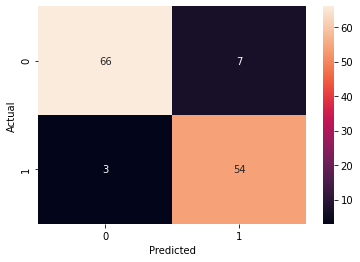

In [6]:
# Build confusion matrix
data = {'y_Actual':  y_Actual,
        'y_Predicted': y_Predicted
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)
plt.show()
